In [3]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from matplotlib.colors import ListedColormap
import warnings; warnings.filterwarnings('ignore')

In [4]:
ds = pd.read_csv('Data/Sheep/Sheep.csv', sep=',')

In [5]:
ds.head(2)

,Unnamed: 0,label,animal_ID,segment_ID,timestamp_ms,ax,ay,az,axhg,ayhg,azhg,cx,cy,cz,gx,gy,gz,pressure,temp
0,0,walking,S1,1,1,-2.73178,-6.68701,-6.57208,2.13233,-5.37588,17.8696,1.5525,-0.4755,0.5415,2.012200,-51.3415,-32.6220,NaN,27.38
1,1,walking,S1,1,6,-2.78206,-6.82347,-6.62954,1.71187,-3.27358,17.3290,NaN,NaN,NaN,-0.121951,-47.3171,-33.5366,NaN,27.39


In [9]:
ds.shape

(4965600, 18)

In [6]:
ds.drop(columns=ds.columns[0], inplace=True)

There are 679 segments present in the following dataset.

Analyzing a segment and it's label.

In [10]:
ds_seg = ds[ds.segment_ID==1]

Here there are 1572 data points in this segment. 

Let's check if the timestamp is continuous.

In [11]:
def checkTimeStampContinuous(TimeSeries):
    if (TimeSeries.diff().unique()[1] == 5.0):
        return True
    else:
        False
checkTimeStampContinuous(ds_seg['timestamp_ms'])

True

Let's find out the number of data points present in each segment.

[]

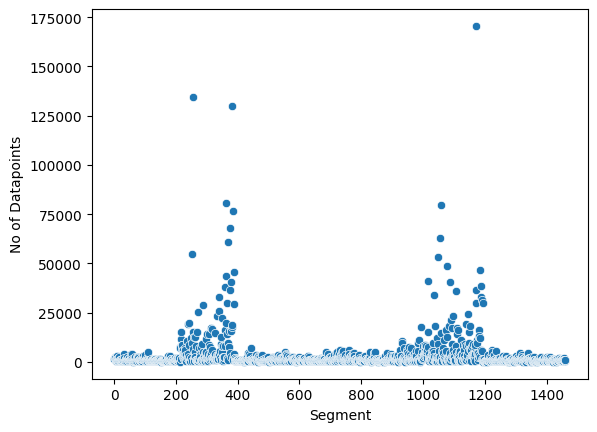

In [12]:
points_per_segment = []

for segment in ds['segment_ID'].unique():
    points_per_segment.append(ds[ds['segment_ID']==segment].shape[0])

sns.scatterplot(x=ds['segment_ID'].unique(),y = points_per_segment)
plt.xlabel('Segment')
plt.ylabel('No of Datapoints')
plt.plot()

Since each segment has uneven number of data points, we have to now check if the data points in each segment have the same label.


In [13]:
def labelCheck(segmentLabelSeries):
    if(len(segmentLabelSeries.unique())==1):
        return True
    else:
        False

for segment in ds['segment_ID'].unique():
    if(labelCheck(ds[ds['segment_ID']==segment]['label'])):
        pass
    else:
        print('Segment {} has a different label set.'.format(segment))

print("Check Completed!")


Check Completed!


Segment Visualization

1461
walking     435
standing    356
trotting    283
running     191
grazing     184
shaking       9
fighting      3
Name: count, dtype: int64


Text(0, 0.5, 'Labels')

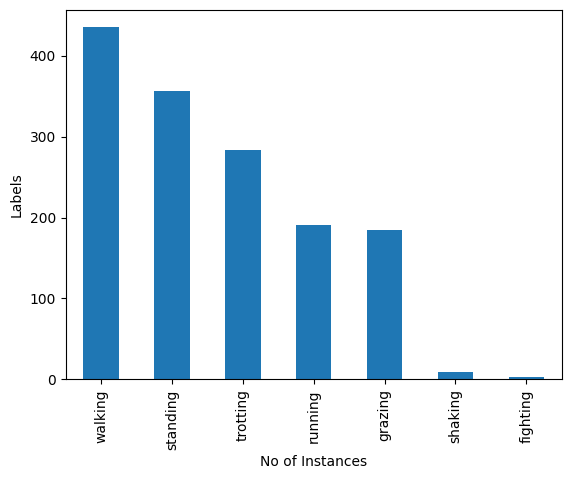

In [14]:
label_per_segment = []

for segment in ds['segment_ID'].unique():
    label_per_segment.append(ds[ds['segment_ID']==segment]['label'].unique()[0])


print(len(label_per_segment))
print(pd.Series(label_per_segment).value_counts())

pd.Series(label_per_segment).value_counts().plot(kind='bar')
plt.xlabel('No of Instances')
plt.ylabel('Labels')

[]

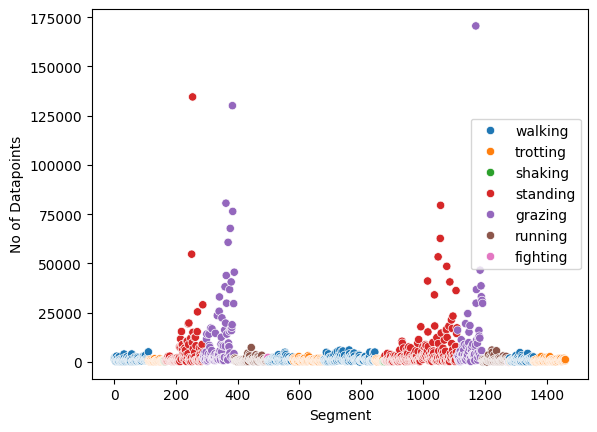

In [15]:
points_per_segment = []
label_per_segment = []

for segment in ds['segment_ID'].unique():
    points_per_segment.append(ds[ds['segment_ID']==segment].shape[0])
    label_per_segment.append(ds[ds['segment_ID']==segment]['label'].unique()[0])

sns.scatterplot(x=ds['segment_ID'].unique(),y = points_per_segment,hue=label_per_segment)
plt.xlabel('Segment')
plt.ylabel('No of Datapoints')
plt.plot()

We can see from the above plot, that the classes are imbalanced. These are the observations:
1. There is only one data point for fighting. So we can not include this in the model for training.
2. The classes standing and shaking appear to be similar, will have to find some evidence to merge the two data points.
3. Technically, the act of grazing and walking can be considered similar, since both sheep usually graze the field walking. (Will need to look into this as well.)


Let's analyse each segments signals to deduce the fluctuation among different classes.

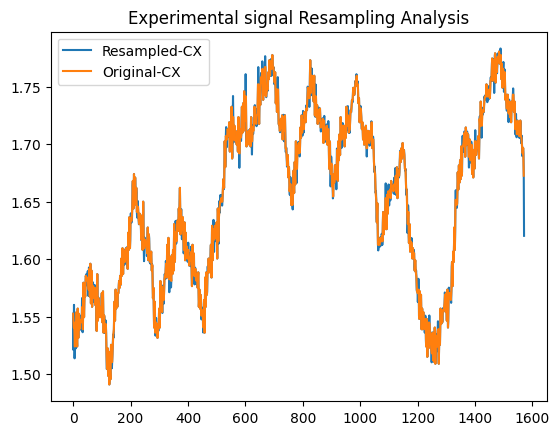

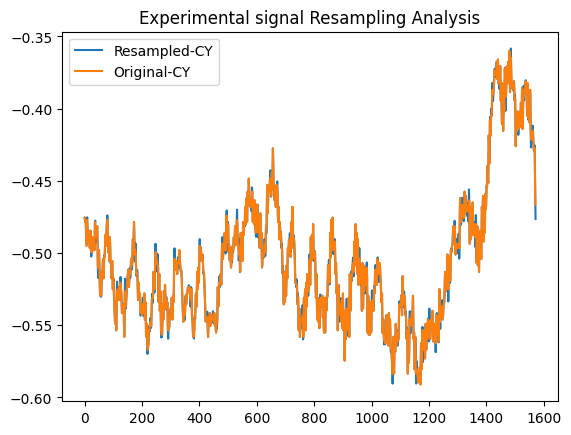

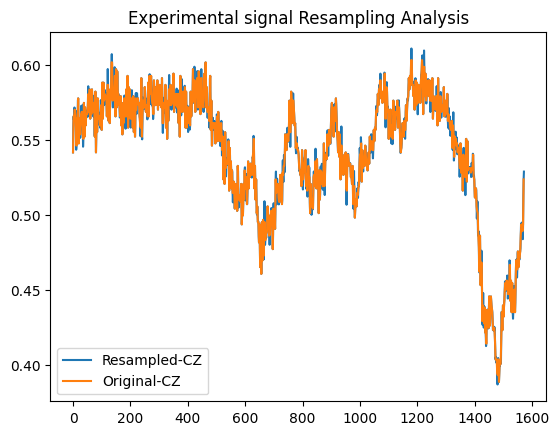

1.6533091603053431


In [16]:
# Experimental Signal Resampling
segment = 1
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CX')
ds[ds['segment_ID']==segment]['cx'].dropna().plot(label='Original-CX')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cy'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CY')
ds[ds['segment_ID']==segment]['cy'].dropna().plot(label='Original-CY')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cz'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CZ')
ds[ds['segment_ID']==segment]['cz'].dropna().plot(label='Original-CZ')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()

print(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())

### Feature Extraction
* Accelerometer Feature
    *   Acceleration
        * Deriving acceleration from accelerometer readings.
        * acceleration = sqrt((ax^2)+(ay^2)+(az^2))
        * Can be applied to High Intensity Accelerometer as well.\
    * %change of Acceleration with time (Average/Segment)

    


In [20]:
# Experiment on segment
ds_seg_fight = ds[ds.segment_ID == 498]
ds_seg_walk = ds[ds.segment_ID == 1]

ds_seg_fight['acceleration'] = np.sqrt((ds_seg_fight['ax']**2)+(ds_seg_fight['ay']**2)+(ds_seg_fight['az']**2))
ds_seg_walk['acceleration'] = np.sqrt((ds_seg_walk['ax']**2)+(ds_seg_walk['ay']**2)+(ds_seg_walk['az']**2))

ds_seg_fight['acc_change_percent'] = ds_seg_fight['acceleration'].pct_change()*100
ds_seg_walk['acc_change_percent'] = ds_seg_walk['acceleration'].pct_change()*100

C:\Users\shara\AppData\Local\Temp\ipykernel_2684\2360630672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_seg_fight['acceleration'] = np.sqrt((ds_seg_fight['ax']**2)+(ds_seg_fight['ay']**2)+(ds_seg_fight['az']**2))
C:\Users\shara\AppData\Local\Temp\ipykernel_2684\2360630672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_seg_walk['acceleration'] = np.sqrt((ds_seg_walk['ax']**2)+(ds_seg_walk['ay']**2)+(ds_seg_walk['az']**2))
C:\Users\shara\AppData\Local\Temp\ipykernel_2684\2360630672.py:8: Se

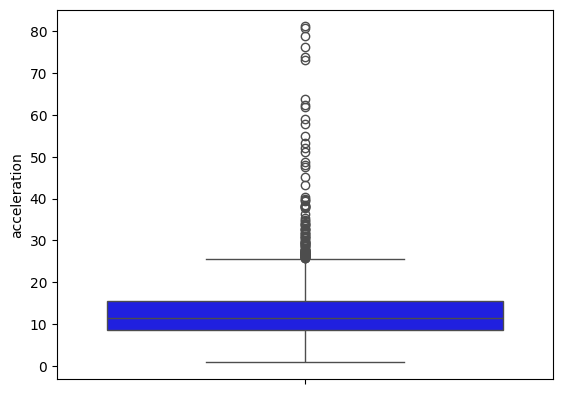

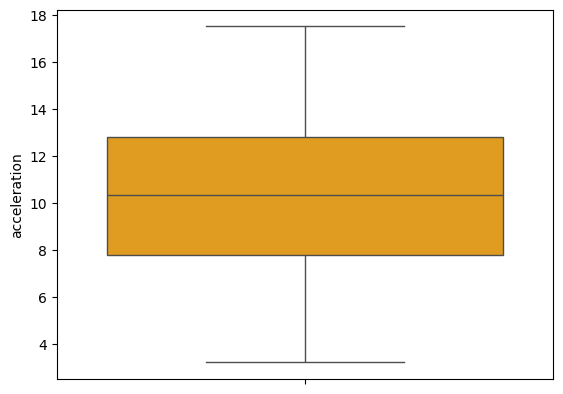

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


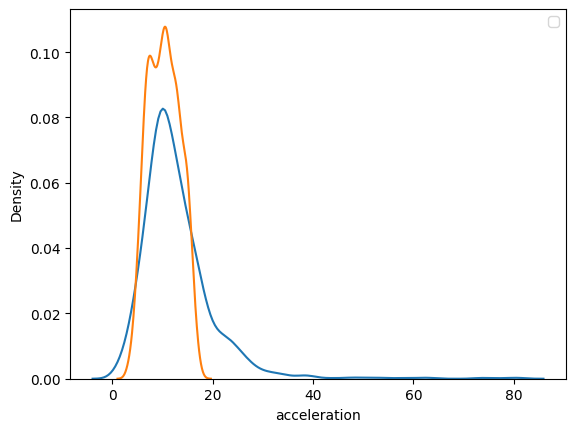

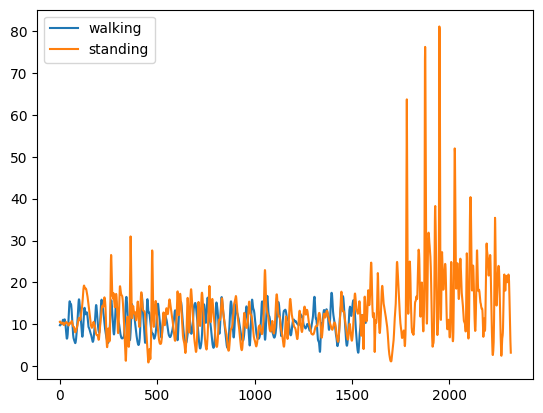

In [23]:
# Visualization on Acceleration Feature
sns.boxplot(ds_seg_fight['acceleration'],color='blue')
plt.show()
sns.boxplot(ds_seg_walk['acceleration'],color='orange')
plt.show()

sns.kdeplot(ds_seg_fight['acceleration'])
sns.kdeplot(ds_seg_walk['acceleration'])
plt.legend()
plt.show()
ds_seg_walk['acceleration'].plot(label='walking')
ds_seg_fight['acceleration'].reset_index(drop=True).plot(label='standing')
plt.legend()
plt.show()


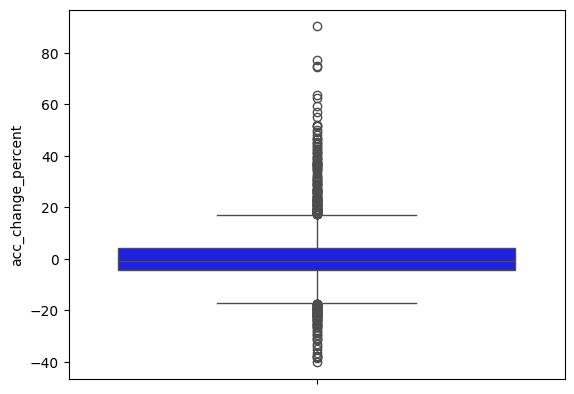

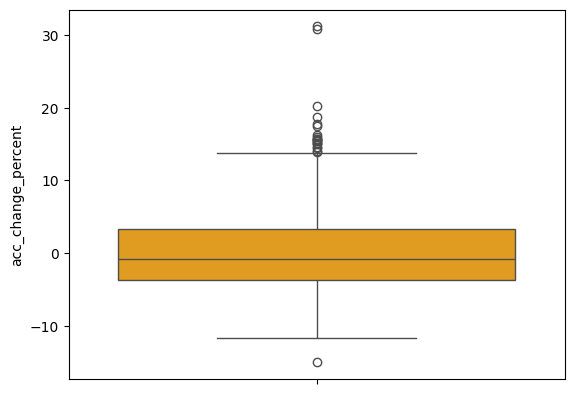

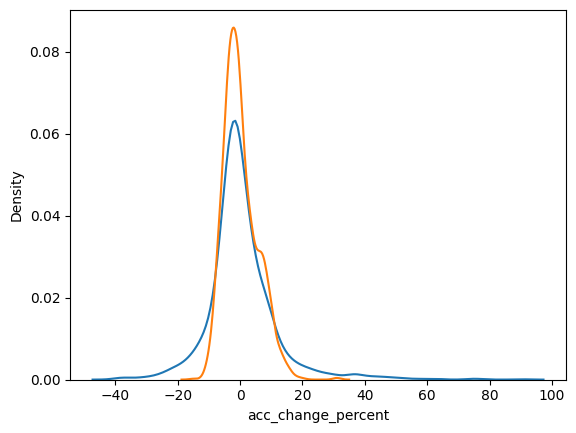

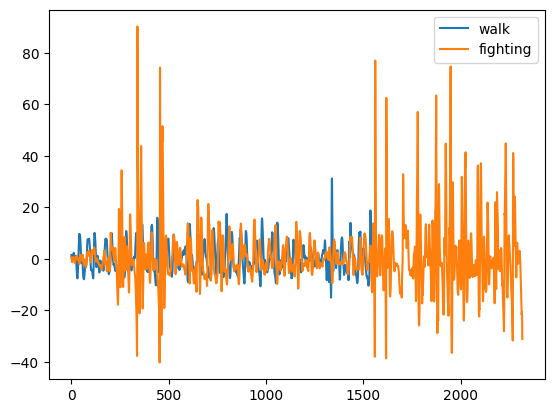

Acceleration Change(%) Fighting: 0.5211818689022857
Acceleration Change(%) Walking: 0.1490961691997132


In [24]:
# Visualization of Acceleration_%_change Feature
sns.boxplot(ds_seg_fight['acc_change_percent'],color='blue')
plt.show()
sns.boxplot(ds_seg_walk['acc_change_percent'],color='orange')
plt.show()

sns.kdeplot(ds_seg_fight['acc_change_percent'])
sns.kdeplot(ds_seg_walk['acc_change_percent'])
plt.show()
ds_seg_walk['acc_change_percent'].plot(label='walk')
ds_seg_fight['acc_change_percent'].reset_index(drop=True).plot(label='fighting')
plt.legend()
plt.show()

print("Acceleration Change(%) Fighting: {}".format(ds_seg_fight['acc_change_percent'].dropna().mean()))
print("Acceleration Change(%) Walking: {}".format(ds_seg_walk['acc_change_percent'].dropna().mean()))

Let's apply this on the entire dataset.

In [25]:
print(ds_seg_walk['acceleration'].diff().abs().mean())
print(ds_seg_fight['acceleration'].diff().abs().mean())

print(ds_seg_walk['acceleration'].mean())
print(ds_seg_fight['acceleration'].mean())

0.41741632473244034
0.9257055241650186
10.34543800304264
12.937998573608244


### Adding features to dataset

In [26]:
ds['acceleration'] = np.sqrt((ds['ax']**2)+(ds['ay']**2)+(ds['az']**2))

<Axes: xlabel='None', ylabel='acceleration'>

c:\Users\shara\Desktop\AnimalCollarMonitoring\AnimalAI\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\shara\Desktop\AnimalCollarMonitoring\AnimalAI\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


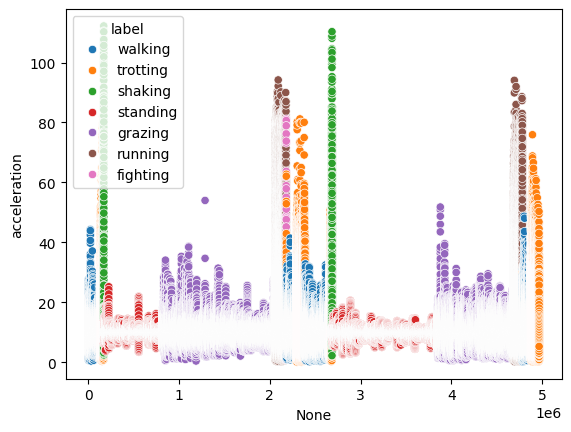

In [29]:
sns.scatterplot(x = ds.index,y = ds.acceleration,hue = ds.label)

### Signal-Segment synthesis

In [30]:
ax_avg = []
ay_avg = []
az_avg = []
axhg_avg = []
ayhg_avg = []
azhg_avg = []
cx_avg = []
cy_avg = []
cz_avg = []
temp_avg = []
press_avg = []
acceleration_avg = []
label = []
segment_id = []
for segment in ds['segment_ID'].unique():
    segment_id.append(segment)
    ax_avg.append(ds[ds['segment_ID']==segment]['ax'].mean())
    ay_avg.append(ds[ds['segment_ID']==segment]['ay'].mean())
    az_avg.append(ds[ds['segment_ID']==segment]['az'].mean())
    acceleration_avg.append(ds[ds['segment_ID']==segment]['acceleration'].mean())

    axhg_avg.append(ds[ds['segment_ID']==segment]['axhg'].mean())
    ayhg_avg.append(ds[ds['segment_ID']==segment]['ayhg'].mean())
    azhg_avg.append(ds[ds['segment_ID']==segment]['azhg'].mean())

    cx_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())
    cy_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cy'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())
    cz_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cz'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())

    temp_avg.append(ds[ds['segment_ID']==segment]['temp'].mean())
    press_avg.append(ds[ds['segment_ID']==segment]['pressure'].mean())
    label.append(ds[ds['segment_ID']==segment]['label'].unique()[0])



synthesized_df = pd.DataFrame({'segment_id':segment_id,
                                'ax_avg':ax_avg,
                                'ay_avg':ay_avg,
                                'az_avg':az_avg,
                                'acc_avg':acceleration_avg,
                                'axhg_avg':axhg_avg,
                                'ayhg_avg':ayhg_avg,
                                'azhg_avg':azhg_avg,
                                'cx_avg':cx_avg,
                                'cy_avg':cy_avg,
                                'cz_avg':cz_avg,
                                'temp_avg':temp_avg,
                                'press_avg':press_avg,
                                'label':label})

In [31]:
synthesized_df.to_csv('./Data/Sheep/Sheep_Proc.csv')

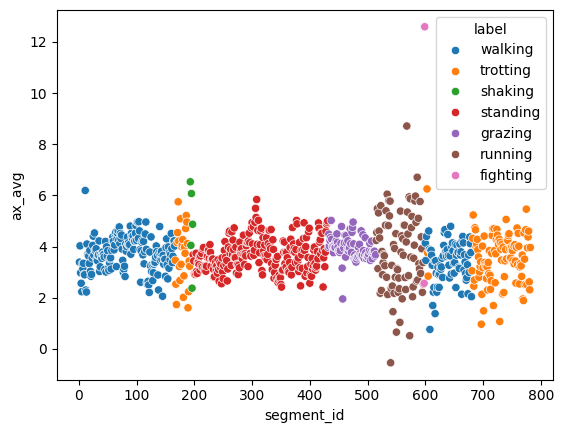

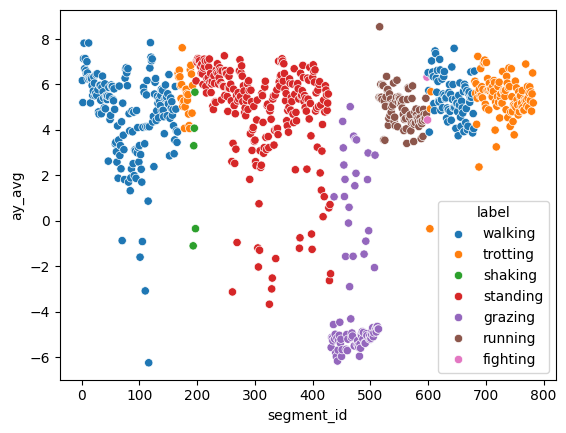

<Axes: xlabel='segment_id', ylabel='az_avg'>

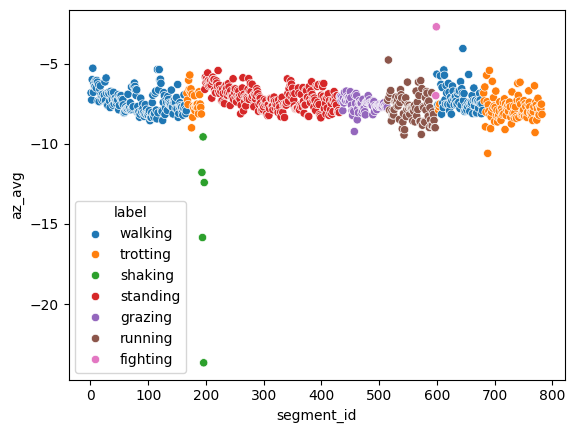

In [117]:
sns.scatterplot(y=synthesized_df['ax_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['ay_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['az_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)

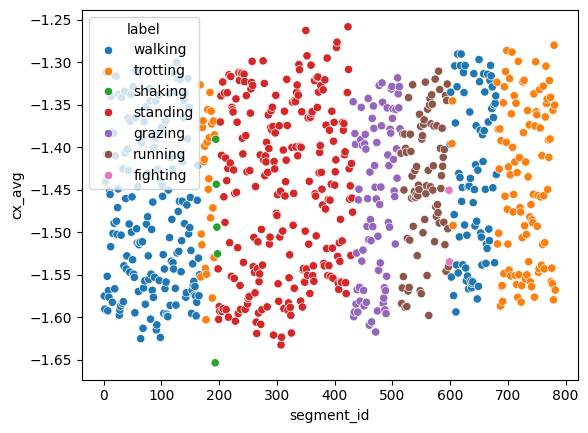

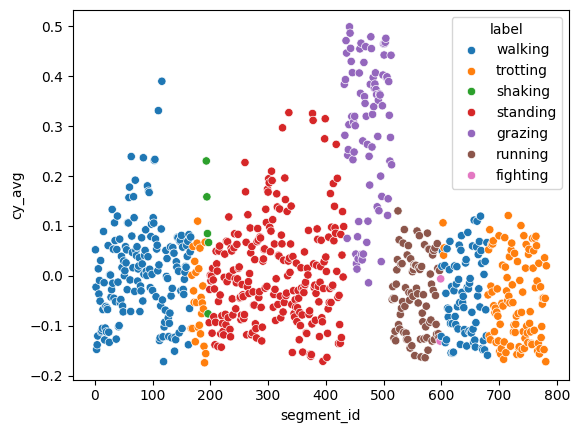

<Axes: xlabel='segment_id', ylabel='cz_avg'>

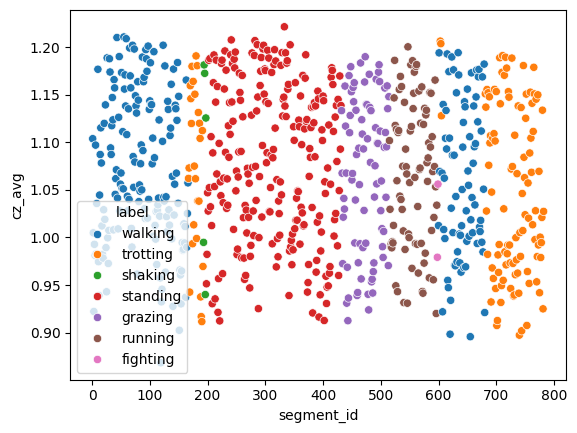

In [113]:
sns.scatterplot(y=synthesized_df['cx_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['cy_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)
plt.show()
sns.scatterplot(y=synthesized_df['cz_avg'],x=synthesized_df['segment_id'],hue=synthesized_df.label)

In [8]:
synthesized_df = pd.read_csv('./Data/Sheep/Sheep_Proc.csv')

In [9]:
synthesized_df.tail()

,Unnamed: 0,segment_id,ax_avg,ay_avg,az_avg,acc_avg,axhg_avg,ayhg_avg,azhg_avg,cx_avg,cy_avg,cz_avg,temp_avg,press_avg,label
1456,1456,1457,4.376322,5.674142,-7.683131,14.955675,6.736177,13.119633,-2.897293,-1.356394,-0.147859,0.994599,31.901591,1008.455921,trotting
1457,1457,1458,4.602588,4.824650,-7.678659,12.111003,7.006296,12.261826,-3.037142,-1.579599,0.036143,1.021011,31.606304,1008.472941,trotting
1458,1458,1459,2.619930,5.582579,-7.820894,12.585988,5.011500,13.137640,-3.271706,-1.279894,-0.045187,1.133634,31.051609,1008.394250,trotting
1459,1459,1460,2.309243,6.505590,-7.530308,14.422785,4.525638,13.935934,-2.842748,-1.350448,-0.172004,0.925032,31.031680,1008.435054,trotting
1460,1460,1461,3.964493,5.187640,-8.164595,13.795493,6.447589,12.701621,-3.681683,-1.567946,0.020139,1.027352,30.968063,1008.518933,trotting


In [10]:
X = synthesized_df.drop(columns=['segment_id','press_avg','temp_avg','label'])
y = synthesized_df['label']
label_encoder = LabelEncoder().fit(y) # label Encoding Target Variable.
y = label_encoder.transform(y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size= 0.15, 
                     stratify= y,
                     random_state= 123)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1241, 11)
X_test shape: (220, 11)


## Modelling

In [54]:
def run_classifier(clf, param_grid, title):
    # -----------------------------------------------------
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'accuracy')
    # -----------------------------------------------------
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    # -----------------------------------------------------
    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred, average= 'weighted')*100))
    # -----------------------------------------------------
    # Plot confusion matrix
    target_names = ['0','1','2','3','4','5']
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")

    plt.show()
    print("-"*20)
    # -----------------------------------------------------

The best parameters are {'solver': 'newton-cg', 'penalty': 'l2'}
Accuracy score: 87.27%
Precision score: 87.13%
Recall score: 87.27%


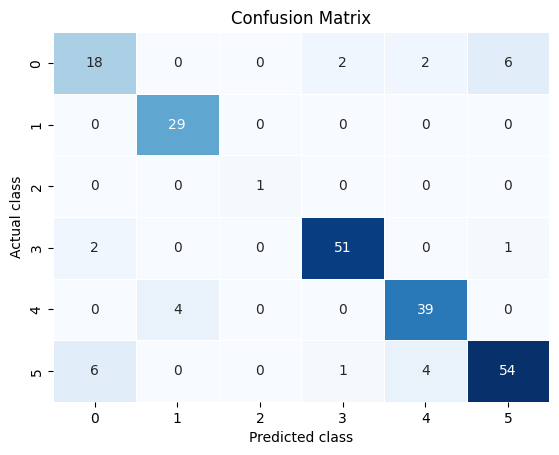

--------------------


In [55]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

param_grid = {'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

run_classifier(lr, param_grid, 'Logistic Regression')